In [1]:
pwd

'/mmfs1/data/aglinska/BC-MRI-AE/Colab Notebooks'

In [2]:
import numpy as np
import pickle
import pandas as pd
from matplotlib import  pyplot as plt
import  seaborn as sns
from helper_funcs import *

from tqdm import tqdm_notebook as tqdm
from datetime import datetime

from scipy import stats

In [3]:
df = pd.read_csv('../Data/ABIDE_legend_S982_pca.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,index,BIDS_ID,Anonymized ID,Subject Type,Visit,Days since enrollment,SubID,DxGroup,...,Medication Name.1,Off stimulants at EPI scan?,ScanSite,ScannerType,ScannerID,ScanSiteID,ADOS_PCA,ADI_PCA,Vineland_PCA,WISC_PCA
0,0,0,0,sub-001,A00033348,PATIENT,session_1,8,51320,1,...,NaN,NaN,mpg,verio,7,3,0,0,0,0
1,1,1,1,sub-002,A00033398,CONTROL,session_1,8,51373,2,...,NaN,NaN,mpg,verio,7,3,0,0,0,0
2,2,2,2,sub-003,A00033352,PATIENT,session_1,8,51324,1,...,NaN,NaN,mpg,verio,7,3,0,0,0,0
3,3,3,3,sub-004,A00033389,CONTROL,session_1,8,51364,2,...,NaN,NaN,mpg,verio,7,3,0,0,0,0
4,4,4,4,sub-005,A00033354,PATIENT,session_1,8,51326,1,...,NaN,NaN,mpg,verio,7,3,0,0,0,0


In [4]:
subs = np.load('../Data/ABIDE-subs-982.npz')['subs']

In [5]:
assert len(subs)==len(df), 'diff lenghts'
assert all([subs[s]==df['BIDS_ID'].values[s] for s in range(len(df))]), 'bad order'

In [6]:
patients = df['DxGroup'].values==1

In [7]:
fn = '../Data/embedded_data.pickle'
data = pickle.load(open(fn,'rb'))
np.array(list(data.keys()))

array(['embedding_bg', 'embedding_sl', 'embedding_vae',
       'sfari_embedding_vae', 'sfari_embedding_bg', 'sfari_embedding_sl',
       'bg_space_abide', 'sl_space_abide', 'vae_space_abide',
       'bg_space_sfari', 'sl_space_sfari', 'vae_space_sfari',
       'bg_Sspace_sfari', 'sl_Sspace_sfari', 'vae_Sspace_sfari',
       'reducer_bg_abide', 'reducer_sl_abide', 'reducer_vae_abide',
       'reducer_bg_sfari', 'reducer_sl_sfari', 'reducer_vae_sfari'],
      dtype='<U19')

In [8]:
for key in data.keys():
    try:
        print(f'{key} | {data[key].shape}')
    except:
        pass

embedding_bg | (470, 16)
embedding_sl | (470, 16)
embedding_vae | (470, 32)
sfari_embedding_vae | (51, 32)
sfari_embedding_bg | (51, 16)
sfari_embedding_sl | (51, 16)
bg_space_abide | (470, 2)
sl_space_abide | (470, 2)
vae_space_abide | (470, 2)
bg_space_sfari | (51, 2)
sl_space_sfari | (51, 2)
vae_space_sfari | (51, 2)
bg_Sspace_sfari | (51, 2)
sl_Sspace_sfari | (51, 2)
vae_Sspace_sfari | (51, 2)


In [9]:
#data_latent = np.load('../Data/latent_vecs100.npz')
data_latent = np.load('../Data/latent_vecs2.npz')
list(data_latent.keys())
print(data_latent['salient_vec_abide'].shape)

(10, 982, 16)


In [10]:
data_latent['salient_vec_abide'][0,:,:]

array([[-0.4272499 ,  0.2735272 , -2.7508783 , ..., -0.91731685,
         0.1433426 , -1.1449697 ],
       [-1.4786693 , -0.7763392 , -1.2325766 , ...,  0.0499858 ,
         0.5017805 ,  0.6354925 ],
       [-2.1715796 ,  1.5461673 ,  0.53020257, ..., -0.15939587,
        -0.6093791 , -0.77931774],
       ...,
       [-0.16703203,  0.08689937, -0.4655738 , ...,  1.1736007 ,
        -0.59409565, -1.0329659 ],
       [-1.2406087 , -0.45388728, -0.7552429 , ..., -1.2301507 ,
         0.5705857 , -2.9799838 ],
       [-1.0072553 , -0.18212083, -0.8699565 , ...,  1.8765252 ,
        -0.291705  , -0.71864563]], dtype=float32)

In [11]:
now = datetime.now
t0 = now()
print(t0)

2021-12-30 08:36:48.107700


In [12]:
%%capture
n = 10 
umap_mat = np.zeros((n,470,2))
for i in tqdm(range(n)):
    umap_mat[i,:,:] = data['reducer_sl_abide'].transform(data_latent['salient_vec_abide'][i,patients,:])

In [13]:
print(now())
print(now()-t0)

2021-12-30 08:37:15.779545
0:00:27.671915


In [14]:
umap_mat.shape

(10, 470, 2)

<ErrorbarContainer object of 3 artists>

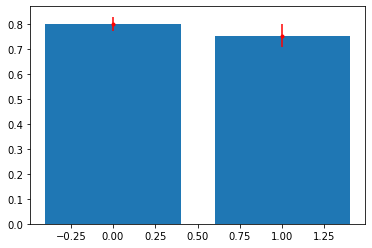

In [15]:
y = [get_triu(np.corrcoef(umap_mat[:,:,0])).mean(),get_triu(np.corrcoef(umap_mat[:,:,1])).mean()]
se = [get_triu(np.corrcoef(umap_mat[:,:,0])).std(),get_triu(np.corrcoef(umap_mat[:,:,1])).std()]
plt.bar([0,1],y)
plt.errorbar([0,1],y,se,fmt='r.')

In [16]:
def plot_error_bar(y,xlbls=None,title=None):
    #y = [r_x,r_y]
    xs = np.arange(len(y))
    m = [val.mean() for val in y]
    se = [val.std() for val in y]
    m = [abs(val) for val in m]
#    m = [abs(val) for val in ]

    t,p = stats.ttest_1samp(y[0],0)
    star_idx = max(np.nonzero(np.float64(p) < [1,.05,.01,.001])[0])
    star_lbls = ['n.s','*','**','***']
    xlbls[0] = xlbls[0]+'\n'+star_lbls[star_idx]

    t,p = stats.ttest_1samp(y[1],0)
    star_idx = max(np.nonzero(np.float64(p) < [1,.05,.01,.001])[0])
    star_lbls = ['n.s','*','**','***']
    xlbls[1] = xlbls[1]+'\n'+star_lbls[star_idx]
    
    plt.bar(xs,m)
    plt.errorbar(xs,m,se,fmt='r.')
    
    #t,p = stats.ttest_rel(y[0],y[1])
    t,p = stats.ttest_rel(abs(y[0]),abs(y[1]))
    star_idx = max(np.nonzero(np.float64(p) < [1,.05,.01,.001])[0])
    yy = max(m)+max(se)
    yy = yy*1.1
    plt.plot([0,1],[yy,yy],'k-',linewidth=3)
    plt.text(.5,yy,star_lbls[star_idx],fontsize=24)
    
    if xlbls:
        plt.xticks(xs,labels=xlbls,fontsize=14)
    if title:
        plt.title(title,fontsize=12)
    plt.ylim(0,yy*1.2)

In [17]:
def plot_scatters(x,ys):
    plt.figure(figsize=np.array((10,5))*.85)
    plt.subplot(1,2,1)
    #x = vec[v]
    #y = umap_mat[i,v,0]
    #print(x.shape)
    #print(ys[0].shape)
    plt.scatter(x,ys[0])

    m,b = np.polyfit(x, ys[0], 1)
    plt.plot(x,m*x+b,'r-',linewidth=3)

    plt.subplot(1,2,2)
    #x,y = vec[v],umap_mat[i,v,1]
    plt.scatter(x,ys[1])

    m,b = np.polyfit(x, ys[1], 1)
    plt.plot(x,m*x+b,'r-',linewidth=3)

In [18]:
n=10

In [19]:
def rdelta_stats(r_x,r_y):
    from scipy import stats
    t,p = stats.ttest_rel(abs(r_x),abs(r_y))
    rdelta = abs(r_x).mean()-abs(r_y).mean()

    if p < .001:
        print(f'Δr = {rdelta:.3f}, t(9) = {t:.2f}, p < .001')
    else:
        print(f'Δr = {rdelta:.3f}, t(9) = {t:.2f}, p = {p:.3f}')

Δr = -0.002, t(9) = -0.12, p = 0.906


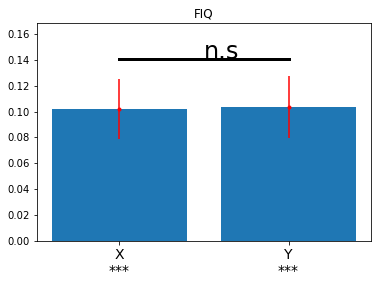

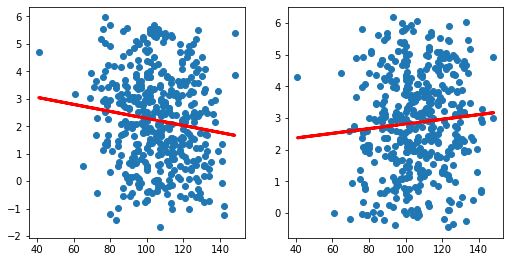

In [20]:
key = 'FIQ'
vec = df[key].values[patients]
v = ~np.isnan(vec)
r_x = np.array([np.corrcoef(vec[v],umap_mat[i,v,0])[0,1] for i in range(n)])
r_y = np.array([np.corrcoef(vec[v],umap_mat[i,v,1])[0,1] for i in range(n)])
plot_error_bar([r_x,r_y],xlbls=['X','Y'],title=key)
plot_scatters(vec[v],[umap_mat[i,v,0],umap_mat[i,v,1]])
rdelta_stats(r_x,r_y)

Δr = 0.042, t(9) = 2.86, p = 0.019


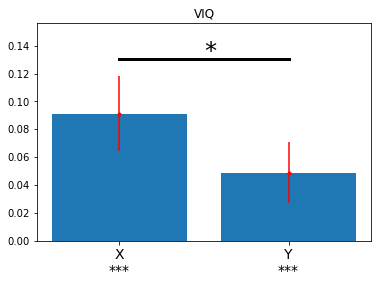

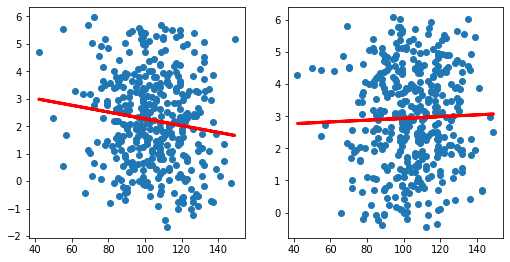

In [21]:
key = 'VIQ'
vec = df[key].values[patients]
v = ~np.isnan(vec)
r_x = np.array([np.corrcoef(vec[v],umap_mat[i,v,0])[0,1] for i in range(n)])
r_y = np.array([np.corrcoef(vec[v],umap_mat[i,v,1])[0,1] for i in range(n)])
plot_error_bar([r_x,r_y],xlbls=['X','Y'],title=key)
plot_scatters(vec[v],[umap_mat[i,v,0],umap_mat[i,v,1]])
rdelta_stats(r_x,r_y)

Δr = 0.036, t(9) = 2.32, p = 0.045


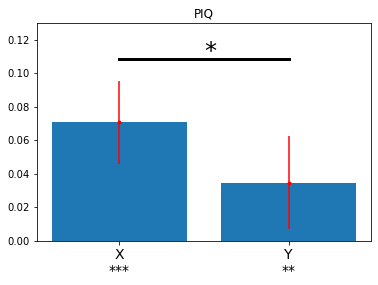

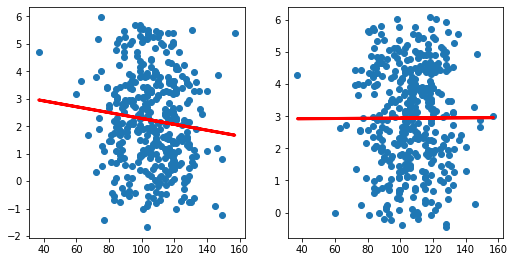

In [22]:
key = 'PIQ'
vec = df[key].values[patients]
v = ~np.isnan(vec)
r_x = np.array([np.corrcoef(vec[v],umap_mat[i,v,0])[0,1] for i in range(n)])
r_y = np.array([np.corrcoef(vec[v],umap_mat[i,v,1])[0,1] for i in range(n)])
plot_error_bar([r_x,r_y],xlbls=['X','Y'],title=key)
plot_scatters(vec[v],[umap_mat[i,v,0],umap_mat[i,v,1]])
rdelta_stats(r_x,r_y)

In [23]:
# import scipy.stats as stats
# stats.ttest_rel(abs(r_x),abs(r_y))

In [24]:
from sklearn.metrics import normalized_mutual_info_score as mi

In [25]:
# key = 'Sex'
# vec = df[key].values[patients]
# v = ~np.isnan(vec)
# # r_x = np.array([np.corrcoef(vec[v],umap_mat[i,v,0])[0,1] for i in range(n)])
# # r_y = np.array([np.corrcoef(vec[v],umap_mat[i,v,1])[0,1] for i in range(n)])
# r_x = np.array([mi(vec[v],umap_mat[i,v,0]) for i in range(n)])
# r_y = np.array([mi(vec[v],umap_mat[i,v,1]) for i in range(n)])
# plot_error_bar([r_x,r_y],xlbls=['X','Y'],title=key)
# #plot_scatters(vec[v],[umap_mat[i,v,0],umap_mat[i,v,1]])

In [26]:
# key = 'AgeAtScan'
# vec = df[key].values[patients]
# v = ~np.isnan(vec)
# r_x = np.array([mi(vec[v],umap_mat[i,v,0]) for i in range(n)])
# r_y = np.array([mi(vec[v],umap_mat[i,v,1]) for i in range(n)])
# plot_error_bar([r_x,r_y],xlbls=['X','Y'],title=key)
# i = 5
# plot_scatters(vec[v],[umap_mat[i,v,0],umap_mat[i,v,1]])

In [77]:
n = 10

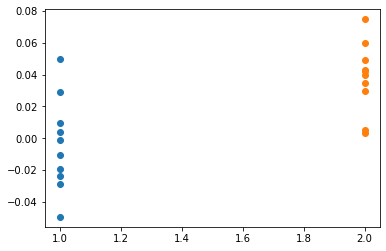

In [86]:
plt.scatter(np.zeros(10)+1,r_x)
plt.scatter(np.zeros(10)+2,r_y)

Δr = -0.016, t(9) = -1.67, p = 0.129


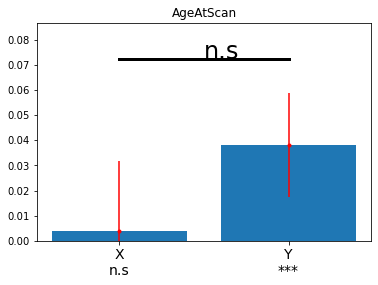

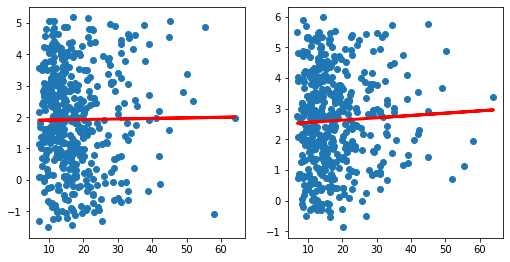

In [78]:
key = 'AgeAtScan'
vec = df[key].values[patients]
v = ~np.isnan(vec)
r_x = np.array([np.corrcoef(vec[v],umap_mat[i,v,0])[0,1] for i in range(n)])
r_y = np.array([np.corrcoef(vec[v],umap_mat[i,v,1])[0,1] for i in range(n)])
plot_error_bar([r_x,r_y],xlbls=['X','Y'],title=key)
i = 5
plot_scatters(vec[v],[umap_mat[i,v,0],umap_mat[i,v,1]])
rdelta_stats(r_x,r_y)

Δr = 0.091, t(9) = 8.71, p < .001


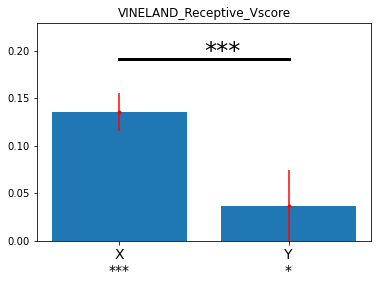

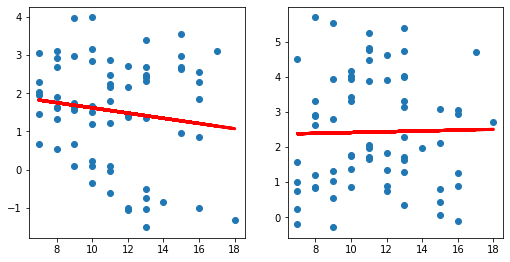

In [28]:
key = 'VINELAND_Receptive_Vscore'
vec = df[key].values[patients]
v = ~np.isnan(vec)
r_x = np.array([np.corrcoef(vec[v],umap_mat[i,v,0])[0,1] for i in range(n)])
r_y = np.array([np.corrcoef(vec[v],umap_mat[i,v,1])[0,1] for i in range(n)])
plot_error_bar([r_x,r_y],xlbls=['X','Y'],title=key)
plot_scatters(vec[v],[umap_mat[i,v,0],umap_mat[i,v,1]])
rdelta_stats(r_x,r_y)

In [29]:
from sklearn.decomposition import PCA

In [30]:
# keys =  ['ADOS_Module', 'ADOS_Total', 'ADOS_ResearchReliability',  'ADOS_Comm', 'ADOS_Social', 'ADOS_StBeh']
# keys = ['ADI_R_SocialTotal', 'ADI_R_VerbalTotal', 'ADI_R_RRB','ADI_R_Onset Total', 'ADI_R_ResearchReliability']
# #keys = ['ADOSGotham_SocAffect', 'ADOSGotham_Rest-RepBeh', 'ADOSGotham_Total', 'ADOSGotham_Severity']
# # keys =  ['VINELAND_Receptive_Vscore',
# #  'VINELAND_Expressive_Vscore',
# #  'VINELAND_Written_Vscore',
# #  'VINELAND_CommunicationStandard',
# #  'VINELAND_Personal_Vscore',
# #  'VINELAND_Domestic_Vscore',
# #  'VINELAND_Community_Vscore',
# #  'VINELAND_DaylyLiving_Standard',
# #  'VINELAND_Interpersonal_Vscore',
# #  'VINELAND_Play_Vscore',
# #  'VINELAND_Coping_Vscore',
# #  'VINELAND_Socical_Standard',
# #  'VINELAND_Domestic_Standard',
# #  'VINELAND_ABC_Standard',
# #  'VINELAND_Informant']



# mat = df[keys].values[patients,:]
# v = np.isnan(mat).sum(axis=1)==0
# mat = mat[v,:]
# #mat = stats.zscore(mat,axis=0)
# reducer = PCA(n_components=1)
# comp = reducer.fit_transform(mat)

# r_x = np.array([np.corrcoef(comp[:,0],umap_mat[i,v,0])[0,1] for i in range(n)])
# r_y = np.array([np.corrcoef(comp[:,0],umap_mat[i,v,1])[0,1] for i in range(n)])
# plot_error_bar([r_x,r_y],xlbls=['X','Y'],title=key)
# plot_scatters(comp[:,0],[umap_mat[i,v,0],umap_mat[i,v,1]])
# #plot_scatters(comp[:,1],[umap_mat[i,v,0],umap_mat[i,v,1]])

# # r_x = np.array([np.corrcoef(comp[:,0],umap_mat[i,v,0])[0,1] for i in range(n)])
# # r_y = np.array([np.corrcoef(comp[:,0],umap_mat[i,v,1])[0,1] for i in range(n)])
# # plot_error_bar([r_x,r_y],xlbls=['X','Y'],title=key)
# # plot_scatters(comp[:,0],[umap_mat[i,v,0],umap_mat[i,v,1]])

Δr = -0.118, t(9) = -4.06, p = 0.003


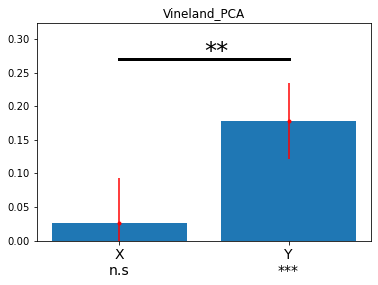

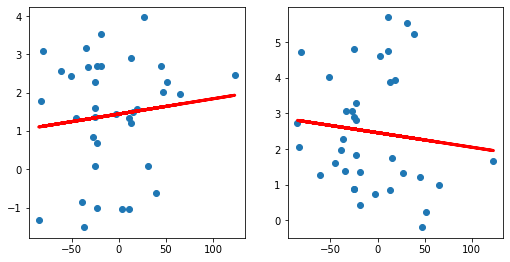

In [31]:
key = 'Vineland_PCA'
vec = df[key].values[patients]
v = ~np.isnan(vec)& vec!=0
r_x = np.array([np.corrcoef(vec[v],umap_mat[i,v,0])[0,1] for i in range(n)])
r_y = np.array([np.corrcoef(vec[v],umap_mat[i,v,1])[0,1] for i in range(n)])
plot_error_bar([r_x,r_y],xlbls=['X','Y'],title=key)
plot_scatters(vec[v],[umap_mat[i,v,0],umap_mat[i,v,1]])
rdelta_stats(r_x,r_y)

Δr = -0.027, t(9) = -1.52, p = 0.162


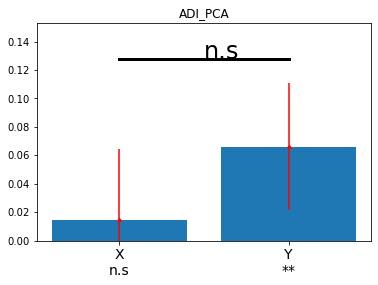

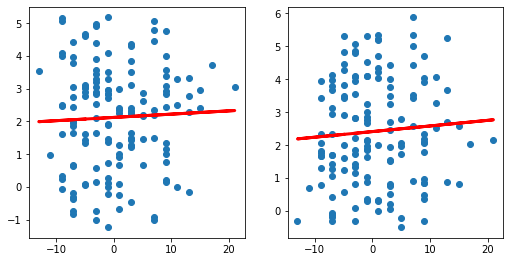

In [32]:
key = 'ADI_PCA'
vec = df[key].values[patients]
v = ~np.isnan(vec) & vec!=0
r_x = np.array([np.corrcoef(vec[v],umap_mat[i,v,0])[0,1] for i in range(n)])
r_y = np.array([np.corrcoef(vec[v],umap_mat[i,v,1])[0,1] for i in range(n)])
plot_error_bar([r_x,r_y],xlbls=['X','Y'],title=key)
plot_scatters(vec[v],[umap_mat[i,v,0],umap_mat[i,v,1]])
rdelta_stats(r_x,r_y)

Δr = -0.028, t(9) = -2.64, p = 0.027


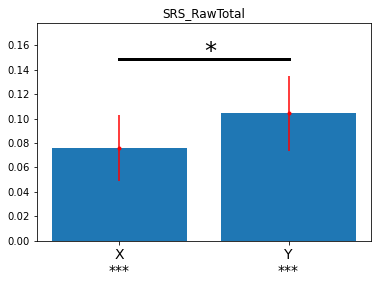

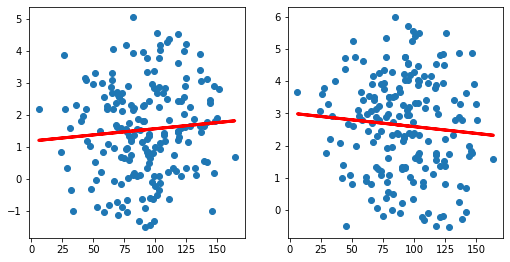

In [33]:
key = 'SRS_RawTotal'
vec = df[key].values[patients]
v = ~np.isnan(vec)
r_x = np.array([np.corrcoef(vec[v],umap_mat[i,v,0])[0,1] for i in range(n)])
r_y = np.array([np.corrcoef(vec[v],umap_mat[i,v,1])[0,1] for i in range(n)])
plot_error_bar([r_x,r_y],xlbls=['X','Y'],title=key)
plot_scatters(vec[v],[umap_mat[i,v,0],umap_mat[i,v,1]])
rdelta_stats(r_x,r_y)

Δr = 0.254, t(9) = 10.12, p < .001


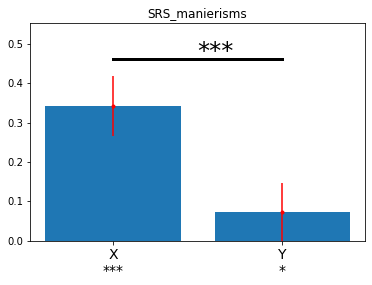

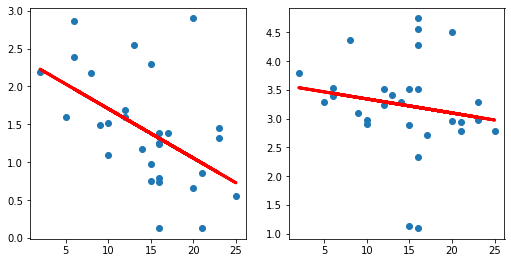

In [34]:
key = 'SRS_manierisms'
vec = df[key].values[patients]
v = ~np.isnan(vec)
r_x = np.array([np.corrcoef(vec[v],umap_mat[i,v,0])[0,1] for i in range(n)])
r_y = np.array([np.corrcoef(vec[v],umap_mat[i,v,1])[0,1] for i in range(n)])
plot_error_bar([r_x,r_y],xlbls=['X','Y'],title=key)
plot_scatters(vec[v],[umap_mat[i,v,0],umap_mat[i,v,1]])
rdelta_stats(r_x,r_y)

Δr = 0.148, t(9) = 4.21, p = 0.002


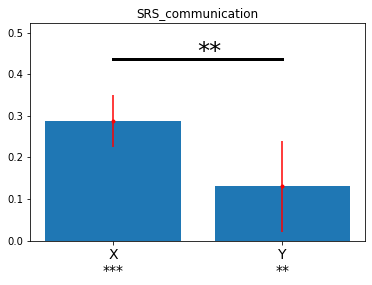

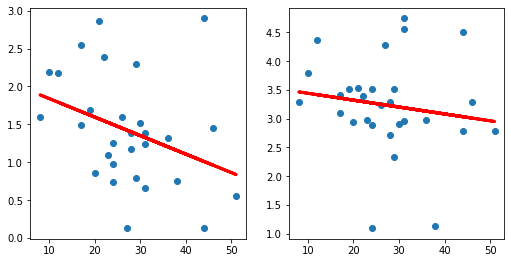

In [35]:
key = 'SRS_communication'
vec = df[key].values[patients]
v = ~np.isnan(vec)
r_x = np.array([np.corrcoef(vec[v],umap_mat[i,v,0])[0,1] for i in range(n)])
r_y = np.array([np.corrcoef(vec[v],umap_mat[i,v,1])[0,1] for i in range(n)])
plot_error_bar([r_x,r_y],xlbls=['X','Y'],title=key)
plot_scatters(vec[v],[umap_mat[i,v,0],umap_mat[i,v,1]])
rdelta_stats(r_x,r_y)

Δr = -0.066, t(9) = -11.33, p < .001


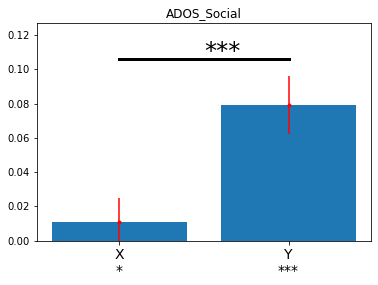

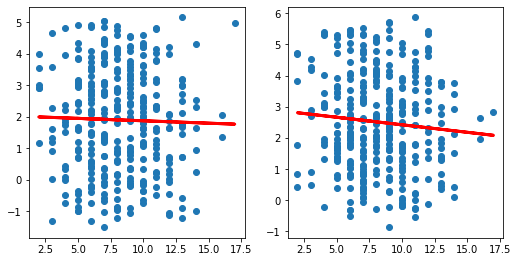

In [36]:
key = 'ADOS_Social'
vec = df[key].values[patients]
v = ~np.isnan(vec)
r_x = np.array([np.corrcoef(vec[v],umap_mat[i,v,0])[0,1] for i in range(n)])
r_y = np.array([np.corrcoef(vec[v],umap_mat[i,v,1])[0,1] for i in range(n)])
plot_error_bar([r_x,r_y],xlbls=['X','Y'],title=key)
plot_scatters(vec[v],[umap_mat[i,v,0],umap_mat[i,v,1]])
rdelta_stats(r_x,r_y)

In [37]:
# plt.scatter(vec[v],umap_mat[i,v,1])
# m, b = np.polyfit(vec[v],umap_mat[i,v,1],1)
# plt.plot(vec[v], m*vec[v] + b,'r-')

Δr = -0.063, t(9) = -9.13, p < .001


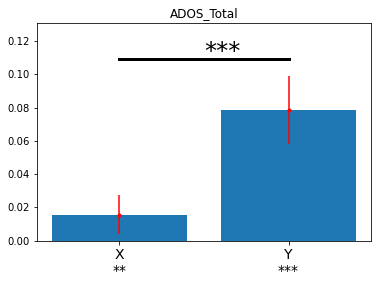

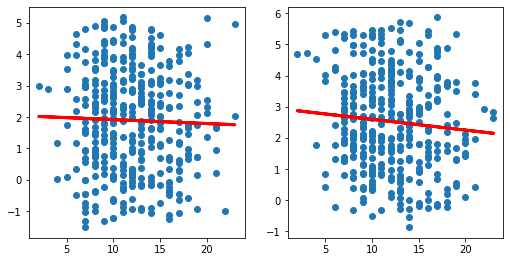

In [38]:
key = 'ADOS_Total'
vec = df[key].values[patients]
v = ~np.isnan(vec)
r_x = np.array([np.corrcoef(vec[v],umap_mat[i,v,0])[0,1] for i in range(n)])
r_y = np.array([np.corrcoef(vec[v],umap_mat[i,v,1])[0,1] for i in range(n)])
plot_error_bar([r_x,r_y],xlbls=['X','Y'],title=key)
plot_scatters(vec[v],[umap_mat[i,v,0],umap_mat[i,v,1]])
rdelta_stats(r_x,r_y)

In [39]:
import sklearn

In [40]:
PCA = sklearn.decomposition.PCA

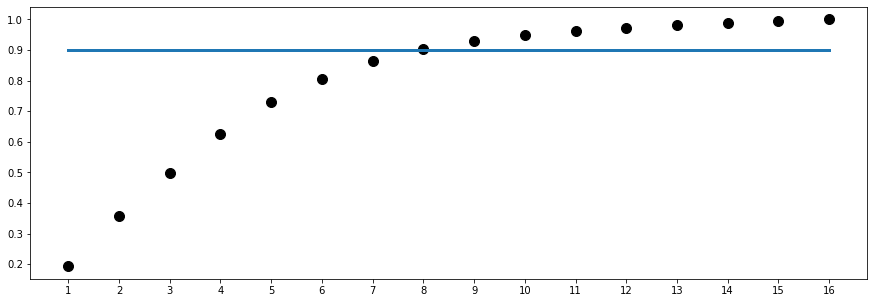

In [41]:
pca = PCA()
comp = pca.fit_transform(data['embedding_bg'])
y = np.cumsum(pca.explained_variance_ratio_)
n = len(y)
x = np.arange(n)
plt.figure(figsize=(15,5))
plt.plot(y,'k.',markersize=20);
plt.plot(x,np.repeat(.9,n),linewidth=3);
plt.xticks(x,labels=x+1);

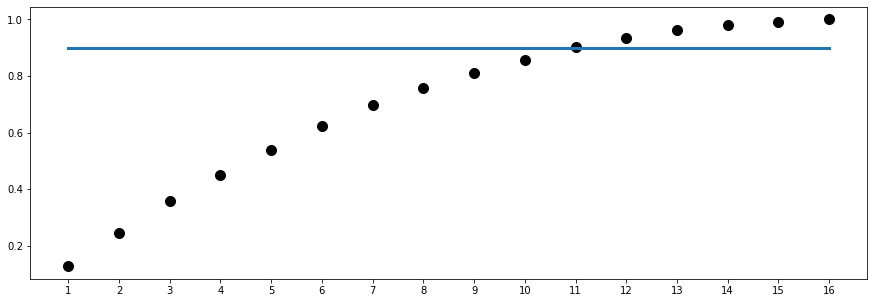

In [42]:
pca = PCA()
comp = pca.fit_transform(data['embedding_sl'])
y = np.cumsum(pca.explained_variance_ratio_)
n = len(y)
x = np.arange(n)
plt.figure(figsize=(15,5))
plt.plot(y,'k.',markersize=20);
plt.plot(x,np.repeat(.9,n),linewidth=3);
plt.xticks(x,labels=x+1);

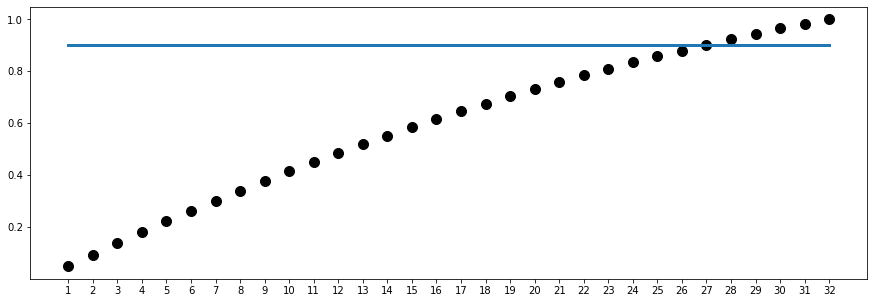

In [43]:
pca = PCA()
comp = pca.fit_transform(data['embedding_vae'])
y = np.cumsum(pca.explained_variance_ratio_)
n = len(y)
x = np.arange(n)
plt.figure(figsize=(15,5))
plt.plot(y,'k.',markersize=20);
plt.plot(x,np.repeat(.9,n),linewidth=3);
plt.xticks(x,labels=x+1);

In [44]:
umap_mat.shape

(10, 470, 2)

In [45]:
# Zobserved = (z1 – z2) / (square root of [ (1 / N1 – 3) + (1 / N2 – 3) ]

In [46]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'index', 'BIDS_ID', 'Anonymized ID',
       'Subject Type', 'Visit', 'Days since enrollment', 'SubID', 'DxGroup',
       'DSMIVTR', 'AgeAtScan', 'Sex', 'FIQ', 'VIQ', 'PIQ', 'IQTest', 'VIQTest',
       'PIQTest', 'ADOS_Module', 'ADOS_Total', 'ADOS_ResearchReliability',
       'ADI_R_SocialTotal', 'ADI_R_VerbalTotal', 'ADI_R_RRB',
       'ADI_R_Onset Total', 'ADI_R_ResearchReliability', 'Handedness_Category',
       'Handedness_Scores', 'ADOS_Comm', 'ADOS_Social', 'ADOS_StBeh',
       'Comorbid_adhd', 'Comorbid_phobia', 'comorbid_anxiety', 'comorbid_all',
       'comorbid_other', 'Comorbidity', 'SRS_RawTotal', 'SRS_Version',
       'SCQ_Total', 'VINELAND_Receptive_Vscore', 'VINELAND_Expressive_Vscore',
       'VINELAND_Written_Vscore', 'VINELAND_CommunicationStandard',
       'VINELAND_Personal_Vscore', 'VINELAND_Domestic_Vscore',
       'VINELAND_Community_Vscore', 'VINELAND_DaylyLiving_Standard',
       'VINELAND_Interpersonal_Vscore', 'VINELAND_Pla

In [47]:
key_list = ['AgeAtScan','FIQ','ADOS_Total','ADOS_Comm', 'ADOS_Social', 'ADOS_StBeh','ADI_R_SocialTotal', 'ADI_R_VerbalTotal', 'ADI_R_RRB','ADI_R_Onset Total',
          'SRS_RawTotal',
       'SCQ_Total',
           'ADOSGotham_SocAffect', 'ADOSGotham_Rest-RepBeh',
       'ADOSGotham_Total', 'ADOSGotham_Severity',
       'AQ Total','ADOS_PCA',
       'ADI_PCA', 'Vineland_PCA', 'WISC_PCA']

key_list = ['AgeAtScan','FIQ','ADOS_Total','ADOS_Comm', 'ADOS_Social', 'ADOS_StBeh','ADI_R_SocialTotal', 'ADI_R_VerbalTotal', 'ADI_R_RRB','ADI_R_Onset Total',
          'SRS_RawTotal',
       'SCQ_Total',
           'ADOSGotham_SocAffect', 'ADOSGotham_Rest-RepBeh',
       'ADOSGotham_Total', 'ADOSGotham_Severity',
       'AQ Total','ADOS_PCA',
       'ADI_PCA', 'Vineland_PCA', 'WISC_PCA','VINELAND_Written_Vscore', 'VINELAND_CommunicationStandard',
       'VINELAND_Personal_Vscore', 'VINELAND_Domestic_Vscore',
       'VINELAND_Community_Vscore', 'VINELAND_DaylyLiving_Standard',
       'VINELAND_Interpersonal_Vscore', 'VINELAND_Play_Vscore',
       'VINELAND_Coping_Vscore', 'VINELAND_Socical_Standard',
       'VINELAND_Domestic_Standard', 'VINELAND_ABC_Standard','WISC4 VCI Verbal Comprehension Index',
       'WISC4 PRI Perceptual Reasoning Index',
       'WISC4 WMI Working Memory Index', 'WISC4 PSI Processing Speed Index',
       'WISC4 Sim Scaled', 'WISC4 Vocab Scaled', 'WISC4 Info Scaled',
       'WISC4 Blk Dsn Scaled', 'WISC4 Pic Con Scaled', 'WISC4 Matrix Scaled',
       'WISC4 Dig Span Scaled', 'WISC4 Let Num Scaled', 'WISC4 Coding Scaled',
       'WISC4 Sym Scaled','VIQ', 'PIQ']

In [48]:
key

'ADOS_Total'

In [49]:
r_list = np.zeros((len(key_list),5))
for idx,key in enumerate(key_list):
    vec = df[key].values[patients]
    v = ~np.isnan(vec)
#     r1 = np.corrcoef(vec[v],umap_mat[0,v,0])[0,1]
#     r2 = np.corrcoef(vec[v],umap_mat[0,v,1])[0,1]

    pr1 = stats.pearsonr(vec[v],umap_mat[0,v,0])
    pr2 = stats.pearsonr(vec[v],umap_mat[0,v,1])
    r_list[idx,0] = pr1[0]
    r_list[idx,1] = pr2[0]
    
    r_list[idx,2] = pr1[1]
    r_list[idx,3] = pr2[1]
    
    r_list[idx,4] = len(vec[v])

In [50]:
dr = pd.DataFrame()

In [51]:
dr['key'] = key_list
dr['rx'] = abs(r_list[:,0])
dr['ry'] = abs(r_list[:,1])
dr['rdelta'] = abs(r_list[:,0])-abs(r_list[:,1])

dr['px'] = r_list[:,2]
dr['py'] = r_list[:,3]
dr['n'] = r_list[:,4]

In [52]:
dr = dr[dr['n']>100]

In [53]:
dr

,key,rx,ry,rdelta,px,py,n
0,AgeAtScan,0.019420,0.034921,-0.015502,0.674540,0.450073,470.0
1,FIQ,0.088868,0.125567,-0.036699,0.066242,0.009310,428.0
2,ADOS_Total,0.005877,0.102170,-0.096293,0.910419,0.049867,369.0
3,ADOS_Comm,0.018366,0.033586,-0.015220,0.734290,0.534713,344.0
4,ADOS_Social,0.001588,0.094452,-0.092864,0.976555,0.079788,345.0
5,ADOS_StBeh,0.124788,0.037666,0.087122,0.035236,0.526539,285.0
6,ADI_R_SocialTotal,0.017100,0.043336,-0.026237,0.764274,0.447081,310.0
7,ADI_R_VerbalTotal,0.026869,0.033072,-0.006203,0.636913,0.561214,311.0
8,ADI_R_RRB,0.088848,0.067068,0.021780,0.118501,0.239032,310.0
9,ADI_R_Onset Total,0.001829,0.013177,-0.011348,0.975559,0.825329,283.0


In [54]:
dr.head()

,key,rx,ry,rdelta,px,py,n
0,AgeAtScan,0.019420,0.034921,-0.015502,0.674540,0.450073,470.0
1,FIQ,0.088868,0.125567,-0.036699,0.066242,0.009310,428.0
2,ADOS_Total,0.005877,0.102170,-0.096293,0.910419,0.049867,369.0
3,ADOS_Comm,0.018366,0.033586,-0.015220,0.734290,0.534713,344.0
4,ADOS_Social,0.001588,0.094452,-0.092864,0.976555,0.079788,345.0


In [55]:
dr.sort_values(by='px',ascending=True).head(5)

,key,rx,ry,rdelta,px,py,n
5,ADOS_StBeh,0.124788,0.037666,0.087122,0.035236,0.526539,285.0
1,FIQ,0.088868,0.125567,-0.036699,0.066242,0.009310,428.0
10,SRS_RawTotal,0.116038,0.104541,0.011496,0.110868,0.151164,190.0
8,ADI_R_RRB,0.088848,0.067068,0.021780,0.118501,0.239032,310.0
47,VIQ,0.057355,0.063902,-0.006546,0.259720,0.209139,388.0


In [56]:
dr.sort_values(by='py',ascending=True).head(5)

,key,rx,ry,rdelta,px,py,n
1,FIQ,0.088868,0.125567,-0.036699,0.066242,0.009310,428.0
2,ADOS_Total,0.005877,0.102170,-0.096293,0.910419,0.049867,369.0
17,ADOS_PCA,0.011589,0.082811,-0.071222,0.802145,0.072877,470.0
4,ADOS_Social,0.001588,0.094452,-0.092864,0.976555,0.079788,345.0
48,PIQ,0.042467,0.082721,-0.040254,0.404795,0.104199,387.0


In [57]:
dr.sort_values(by='rdelta',ascending=False).head()

,key,rx,ry,rdelta,px,py,n
5,ADOS_StBeh,0.124788,0.037666,0.087122,0.035236,0.526539,285.0
8,ADI_R_RRB,0.088848,0.067068,0.021780,0.118501,0.239032,310.0
10,SRS_RawTotal,0.116038,0.104541,0.011496,0.110868,0.151164,190.0
18,ADI_PCA,0.017244,0.018431,-0.001187,0.709246,0.690226,470.0
19,Vineland_PCA,0.002369,0.005586,-0.003216,0.959142,0.903873,470.0


In [58]:
dr_sorted = dr.sort_values(by='rdelta',ascending=True)
dr_sorted.head()

,key,rx,ry,rdelta,px,py,n
2,ADOS_Total,0.005877,0.102170,-0.096293,0.910419,0.049867,369.0
4,ADOS_Social,0.001588,0.094452,-0.092864,0.976555,0.079788,345.0
17,ADOS_PCA,0.011589,0.082811,-0.071222,0.802145,0.072877,470.0
48,PIQ,0.042467,0.082721,-0.040254,0.404795,0.104199,387.0
1,FIQ,0.088868,0.125567,-0.036699,0.066242,0.009310,428.0


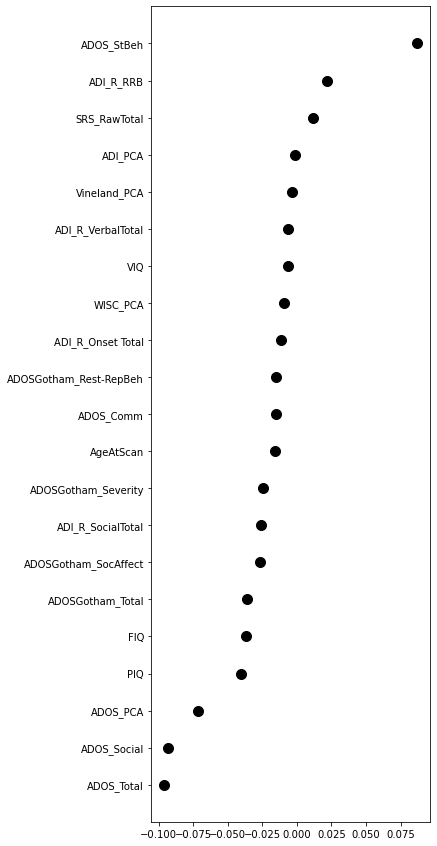

In [59]:
y = dr_sorted['rdelta'].values
x = np.arange(len(y))
lbls = dr_sorted['key'].values

plt.figure(figsize=(5,15))
plt.plot(y,x,'k.',markersize=20)
plt.yticks(x,labels=lbls,rotation=0);

In [60]:
dr.sort_values(by='rx',ascending=False).head()

,key,rx,ry,rdelta,px,py,n
5,ADOS_StBeh,0.124788,0.037666,0.087122,0.035236,0.526539,285.0
10,SRS_RawTotal,0.116038,0.104541,0.011496,0.110868,0.151164,190.0
1,FIQ,0.088868,0.125567,-0.036699,0.066242,0.009310,428.0
8,ADI_R_RRB,0.088848,0.067068,0.021780,0.118501,0.239032,310.0
14,ADOSGotham_Total,0.073660,0.109861,-0.036200,0.304871,0.125312,196.0


In [61]:
dr.sort_values(by='ry',ascending=False).head()

,key,rx,ry,rdelta,px,py,n
1,FIQ,0.088868,0.125567,-0.036699,0.066242,0.009310,428.0
14,ADOSGotham_Total,0.073660,0.109861,-0.036200,0.304871,0.125312,196.0
10,SRS_RawTotal,0.116038,0.104541,0.011496,0.110868,0.151164,190.0
2,ADOS_Total,0.005877,0.102170,-0.096293,0.910419,0.049867,369.0
4,ADOS_Social,0.001588,0.094452,-0.092864,0.976555,0.079788,345.0


In [62]:
import scipy

In [63]:
linkage = scipy.cluster.hierarchy.linkage
dendrogram = scipy.cluster.hierarchy.dendrogram

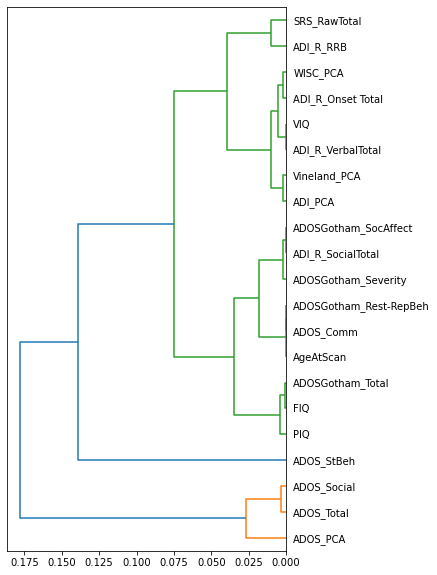

In [64]:
plt.figure(figsize=(5,10))
Z = linkage(1-dr['rdelta'].values[:,np.newaxis],'ward')
dendrogram(Z,0,orientation='left',labels=dr['key'].values);

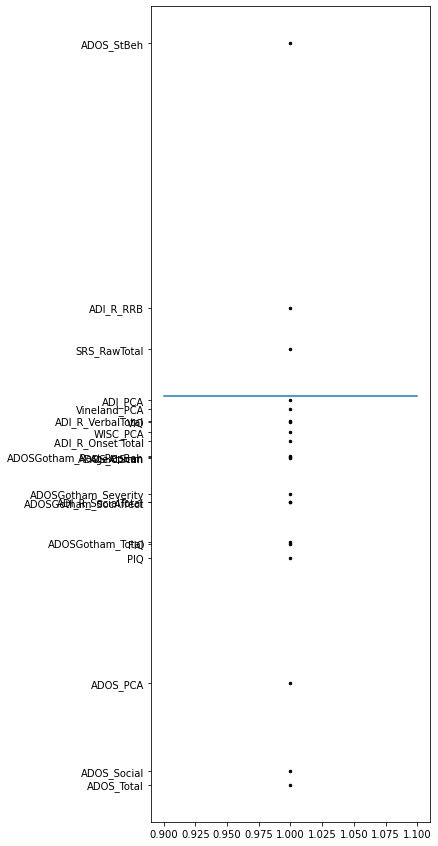

In [65]:
dr = dr[dr['n']>150]
c = len(dr)
plt.figure(figsize=(5,15))
plt.plot(np.ones(c),dr['rdelta'].values,'k.',markersize=5)
plt.yticks(dr['rdelta'].values,labels=dr['key'].values,rotation=0);
plt.plot([.9,1.1],[0,0])

In [66]:
## REGRESSION with 16 dimensions

In [67]:
list(data_latent.keys())

['salient_vec_abide',
 'background_vec_abide',
 'vae_vec_abide',
 'salient_vec_sfari',
 'background_vec_sfari',
 'vae_vec_sfari']

In [68]:
data_latent['salient_vec_abide'].shape

(10, 982, 16)

In [69]:
# >>> import numpy as np
# >>> from sklearn.linear_model import LinearRegression
# >>> X = np.array([[1, 1], [1, 2], [2, 2], [2, 3]])
# >>> # y = 1 * x_0 + 2 * x_1 + 3
# >>> y = np.dot(X, np.array([1, 2])) + 3
# >>> reg = LinearRegression().fit(X, y)
# >>> reg.score(X, y)
# 1.0
# >>> reg.coef_
# array([1., 2.])
# >>> reg.intercept_
# 3.0...
# >>> reg.predict(np.array([[3, 5]]))
# array([16.])

In [70]:
keys = ['AgeAtScan', 'Sex', 'FIQ', 'VIQ', 'PIQ','ADOS_Total', 'ADOS_Comm', 'ADOS_Social', 'ADOS_StBeh','SRS_awareness', 'SRS_cognition', 'SRS_communication',
       'SRS_motivation', 'SRS_manierisms']

LinearRegression = sklearn.linear_model.LinearRegression

coefss = list()
for i in range(10):
    coefs = list()
    for key in keys:
       #X = data_latent['salient_vec_abide'][i,patients,:]
        X = data_latent['background_vec_abide'][0,patients,:]
        #X = data_latent['vae_vec_abide'][0,patients,:]
        Y = df[key].values[patients]
        v = ~np.isnan(Y)

        X = X[v,:]
        Y = Y[v]

        reg = LinearRegression().fit(X, Y)
        coefs.append(reg.coef_)
    coefss.append(coefs)

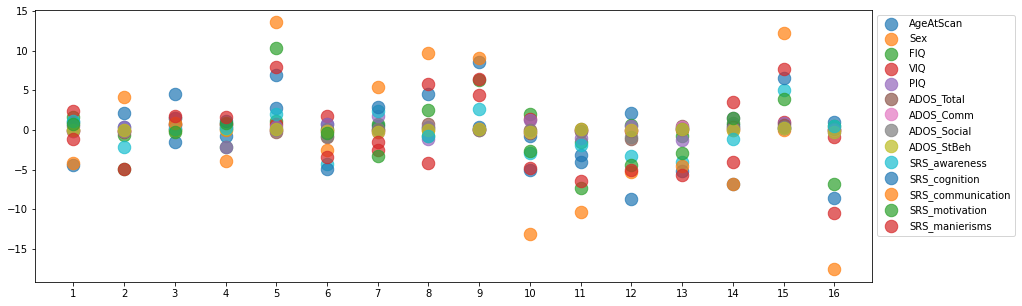

In [71]:
plt.figure(figsize=(15,5))
coef_mat = np.array(coefs).transpose()
coef_mat = np.array(coefss).mean(axis=0).transpose()
plt.plot(coef_mat,'.',markersize=25,alpha=.7)
plt.legend(keys,bbox_to_anchor=(1.0, 1), loc='upper left')
plt.xticks(np.arange(16),labels=np.arange(16)+1);

In [72]:
keys = ['Sex','DSMIVTR']

LinearRegression = sklearn.linear_model.LinearRegression
coefs = list()

for key in keys:
    X = data_latent['salient_vec_abide'][0,patients,:]
    #X = data_latent['background_vec_abide'][0,patients,:]
    #X = data_latent['vae_vec_abide'][0,patients,:]
    Y = df[key].values[patients]
    v = ~np.isnan(Y)

    X = X[v,:]
    Y = Y[v]

    reg = LinearRegression().fit(X, Y)
    coefs.append(reg.coef_)

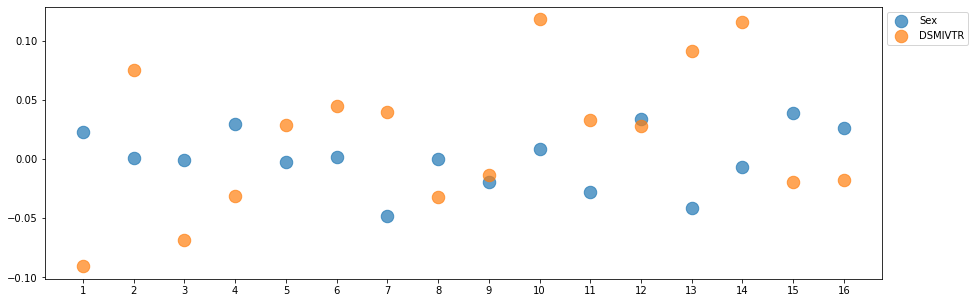

In [73]:
plt.figure(figsize=(15,5))
coef_mat = np.array(coefs).transpose()
plt.plot(coef_mat,'.',markersize=25,alpha=.7)
plt.legend(keys,bbox_to_anchor=(1.0, 1), loc='upper left')
plt.xticks(np.arange(16),labels=np.arange(16)+1);

In [74]:
# Y = scipy.spatial.distance.pdist(coef_mat.transpose(),metric='euclidean')
# Z = linkage(Y,'ward');
# dendrogram(Z,orientation='left',labels=keys);